Import modules

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import scipy.stats as stats
import scipy.optimize as opt
import json as json
import matplotlib as mpl
from math import exp
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
from IPython.display import display
from IPython.core.display import HTML
rnd.seed(2)
import warnings
warnings.filterwarnings('ignore')

## Data generating

milage transition

In [2]:
#arbitrarily choosen paramteres
lower, upper = 0, 15000
mu, sigma = 6000, 4000
mileage_dist = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

In [3]:
#calculating transition probabilities
p_x0 = mileage_dist.cdf(5000)
p_x1 = mileage_dist.cdf(10000) - p_x0
p_x2 = 1 - p_x1 - p_x0
p = (p_x0, p_x1, p_x2)

agent decision

In [4]:
#initializing paramters
rc = 20
theta1_1 = 0.5
theta1_2 = 0.01
beta = 0.75

In [5]:
def myopic_costs(S, MF, params, p):
    """
    This function computes the myopic expected cost associated with each decision for each state, 
    and returns an array of state/decision costs.
    
    Takes:
        * An integer S, describing the possible states of the bus
        * A maintenance cost function MF, which takes a vector of parameters and a `state' argument
        * A vector params, to be supplied to the maintenance cost function MF. The first element of 
          the vector is the replacement cost rc.
        * A (3x1) vector p describing the state transitions probabilities 
        
    Returns:
        * A (Nx2) array containing the maintenance and replacement costs for the N possible states of the bus
    """
    rc = params[0]
    maint_cost = [MF(s, params[1:]) for s in range(0, S)]
    repl_cost = [rc for state in range(0, S)]
    return np.vstack((maint_cost, repl_cost)).T

In [6]:
def lin_cost(s, params):
    try:
        theta1_1, = params
        return s*theta1_1
    except ValueError:
        raise ValueError
        print("Wrong number of parameters specified: expected 2, got {}".format(len(params)))

In [7]:
def choice_prob(cost_array):
    """
    Returns the probability of each choice, conditional on an array of state/decision costs.
    """
    S = cost_array.shape[0]
    cost = cost_array - cost_array.min(1).reshape(S, -1)
    util = np.exp(-cost)
    pchoice = util/(np.sum(util, 1).reshape(S, -1))
    return pchoice

In [8]:
def contraction_mapping(
    S, p, MF, params, beta=0.75, threshold=1e-6, suppr_output=False
):
    """
    Compute the non-myopic expected value of the agent for each possible decision and each possible
    state of the bus.
    Iterate until the difference in the previously obtained expected value and the new expected value
    is smaller than a constant.
    Takes:
        * A finite number of states S
        * A state-transition probability vector p = [p(0), p(1), p(2), ..., p(k)] of length k < N
        * A maintenance cost function MF
        * A vector params for the cost function
        * A discount factor beta (optional)
        * A convergence threshold (optional)

    Returns:
        * The converged choice probabilities for the forward-looking and myopic agents for each state,
        conditional on `params'
    """
    achieved = True
    # Initialization of the state-transition matrices: describe the state-transition probabilities
    # if the maintenance cost is incurred, and regenerate the state to 0 if the replacement cost
    # is incurred.
    ST_mat = np.zeros((S, S))
    p = np.array(p)
    for i in range(S):
        for j, _p in enumerate(p):
            if i + j < S - 1:
                ST_mat[i + j][i] = _p

            elif i + j == S - 1:
                ST_mat[S - 1][i] = p[j:].sum()
            else:
                pass

    R_mat = np.vstack((np.ones((1, S)), np.zeros((S - 1, S))))

    # Initialization of the expected value (which is also the myopic
    # decision cost of the agent). Here, the forward-looking component is initialized at 0.
    k = 0
    EV = np.zeros((S, 2))
    EV_myopic = EV_new = myopic_costs(S, MF, params, p)
    # Contraction mapping loop
    while abs(EV_new - EV).max() > threshold:
        # Store the former expected value
        EV = EV_new
        # Obtained the probability of maintenance and replacement from the former expected value
        pchoice = choice_prob(EV)
        # Compute the expected cost for each state: Nx1 vector
        ecost = (pchoice * EV).sum(1)
        # Compute the two components of forward-looking utility: In case of maintenance,
        # utility of future states weighted by transition probabilities. In case of replacement,
        # the future utility is the utility of state 0
        futil_maint = np.dot(ecost, ST_mat)
        futil_repl = np.dot(ecost, R_mat)
        futil = np.vstack((futil_maint, futil_repl)).T
        # Future utility is discounted by beta, and added to the myopic cost.
        EV_new = EV_myopic + beta * futil
        k += 1
        if k == 1000:
            achieved = False
            break

    if not suppr_output:
        if achieved:
            print("Convergence achieved in {} iterations".format(k))
        else:
            print(
                "CM could not converge! Mean difference = {:.6f}".format(
                    (EV_new - EV).mean()
                )
            )

    return (choice_prob(EV_new), choice_prob(EV_myopic), EV_new)

generating the simulated data

In [9]:
params_lin = (rc, theta1_1)
p = (p_x0, p_x1, p_x2)
lin_forward, lin_myopic, lin_forward_util = contraction_mapping(
    S=70, p=p, MF=lin_cost, params=params_lin, beta=0.75
)
pchoice = lin_forward.T[0]

Convergence achieved in 54 iterations


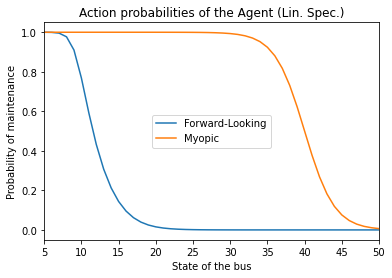

In [10]:
plt.plot(lin_forward.T[0])
plt.plot(lin_myopic.T[0])
plt.ylabel("Probability of maintenance")
plt.xlabel("State of the bus")
plt.legend(["Forward-Looking", "Myopic"])
plt.xlim(5, 50)
plt.title("Action probabilities of the Agent (Lin. Spec.)");

## Bus replacement

In [11]:
n_bus = 1
init_bus_array_0 = np.hstack(
    (
        np.linspace(1, n_bus, n_bus).reshape(-1, 1),
        np.zeros((n_bus, 3)),
        np.random.gumbel(size=(n_bus, 2)),
    )
)
init_bus_array_1 = np.hstack(
    (
        np.linspace(1, n_bus, n_bus).reshape(-1, 1),
        np.ones((n_bus, 1)),
        np.zeros((n_bus, 2)),
        np.random.gumbel(size=(n_bus, 2)),
    )
)

In [12]:
def decide(s, pchoice):
    """
    Make a decision to maintain or replace the bus, based on a probability of choice p
    and a current state s
    """
    s = int(s)

    return np.random.choice([0, 1], p=[pchoice[s], 1 - pchoice[s]])


def transition(bus_array, p):
    """
    Return the updated bus dataset after one decision of our agent.
    Takes:
        * bus_array : An array of buses, containing the identifier of the buses, their mileages, and their current
                        state.
        * pchoice : The converged choice probabities of the agent making the decision

    Returns:
        * The updated dataset of buses, with the new decisions appended at the end of the dataframe.
    """
    # Recovering the number of buses, the previous mileage and the previous states of the buses
    n_bus = int(bus_array[:, 0].max())
    prev_mileage = bus_array[-n_bus:, 2]
    prev_states = bus_array[-n_bus:, 3]
    # Generating choices from choice probabilities, conditional on the state of each bus
    choices = np.array([decide(x, pchoice) for x in prev_states])

    # Generating the new mileage and state
    new_mileage = (1 - choices) * prev_mileage + mileage_dist.rvs(size=n_bus)
    new_states = np.floor(new_mileage / 5000)
    new_array = np.vstack(
        (
            bus_array[-n_bus:, 0],
            np.zeros(n_bus),
            new_mileage,
            new_states,
            np.random.gumbel(size=(2, n_bus)),
        )
    )
    bus_array[-n_bus:, 1] = choices
    return np.vstack((bus_array, new_array.T))

In [13]:
n_periods = 1000

In [14]:
def calculate_utility(bus_array, lin_cost, params_lin, beta):
    lin_dataframe = pd.DataFrame(
        bus_array, columns=["Identifier", "Choice", "Mileage", "State", "ϵ0", "ϵ1"]
    )

    lin_dataframe["Relative_ERepl"] = (
        lin_dataframe.groupby("State")["Choice"]
        .transform("mean")
        .apply(lambda x: np.where(x == 0, -1 * np.inf, np.log(x)))
    )

    lin_dataframe["simulatied_choice"] = np.where(
        (lin_dataframe["Relative_ERepl"] + lin_dataframe["ϵ1"] - lin_dataframe["ϵ0"])
        > 0,
        1,
        0,
    )

    lin_dataframe["t"] = lin_dataframe.index

    maintenance_cost = myopic_costs(
        int(lin_dataframe["State"].max()), lin_cost, params_lin, _
    ).T[0]
    replacement_cost = myopic_costs(
        int(lin_dataframe["State"].max()), lin_cost, params_lin, _
    ).T[1]

    Maintenance_Cost = (
        pd.DataFrame(maintenance_cost)
        .reset_index()
        .rename(columns={"index": "State", 0: "maintenance_cost"})
    )
    Replacement_Cost = (
        pd.DataFrame(replacement_cost)
        .reset_index()
        .rename(columns={"index": "State", 0: "replacement_cost"})
    )

    lin_dataframe = lin_dataframe.merge(Maintenance_Cost, on="State", how="left").merge(
        Replacement_Cost, on="State", how="left"
    )

    lin_dataframe = lin_dataframe.assign(
        util=lambda x: np.where(
            x["simulatied_choice"] == 0,
            -1 * (x["maintenance_cost"]) + x["ϵ0"],
            -1 * (x["replacement_cost"]) + x["ϵ1"],
        )
    )

    lin_dataframe["β"] = beta
    u1=lin_dataframe.iloc[0, -2]
    v1_v0=lin_dataframe.iloc[0, -2]

    return ((
        (lin_dataframe["β"] ** (lin_dataframe["t"] - 1)) * lin_dataframe["util"]
    ).sum(),u1)

In [15]:
U0 = []
for i in range(1,101):
    n_periods = 1000
    bus_array=init_bus_array_0
    if i%10==0:
        print(i)
    for j in range(n_periods):
        bus_array = transition(bus_array, pchoice)
    u = calculate_utility(bus_array, lin_cost, params_lin, beta)
    U0.append(u[0])
u_1_0=u[1]
print(u_1_0)

10
20
30
40
50
60
70
80
90
100
-0.2542532557870629


In [16]:
U1 = []
for i in range(1,101):
    n_periods = 1000
    bus_array=init_bus_array_1
    if i%10==0:
        print(i)
    for j in range(n_periods):
        bus_array = transition(bus_array, pchoice)
    u = calculate_utility(bus_array, lin_cost, params_lin, beta)
    U1.append(u[0])
u_1_1=u[1]
print(u_1_1)

10
20
30
40
50
60
70
80
90
100
-0.8279078881779832


In [17]:
U0_mean=np.mean(U0)

In [18]:
U1_mean=np.mean(U1)

In [19]:
rel_EV_repl=u_1_1+U1_mean-u_1_0-U0_mean
exp(rel_EV_repl)

0.12478659325623041